In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [75]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [76]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [77]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [78]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [79]:
# Assign the measurement class to a variable called `Measurement` and the station class to a variable called `Station`
measurement = Base.classes.measurement
station = Base.classes.station

In [80]:
# Create session and how it connects
session = Session(engine)
conn = engine.connect()

In [81]:
from sqlalchemy import text
query = text("""SELECT * from station limit 10""")
dataframe_one = pd.read_sql(query, con=conn)
print(dataframe_one.shape)
dataframe_one


(9, 6)


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Precipitation Analysis

In [82]:
# Find the most recent date in the data set.
query = text("""SELECT max(date) from measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

In [83]:
last_date_str = session.query(func.max(measurement.date)).scalar()
last_date_str

'2017-08-23'

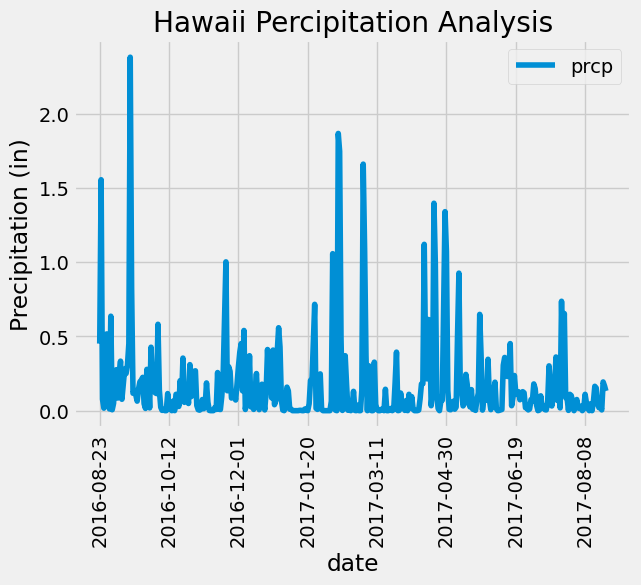

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
last_date = dt.date.fromisoformat(last_date_str)

# Calculate the date one year from the last date in data set.
year_before_date = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
prcp = session.query(measurement.date, func.avg(measurement.prcp))\
    .filter(measurement.date >= year_before_date)\
    .group_by(measurement.date)\
    .order_by(measurement.date)\
    .all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp, columns=['date','prcp']).sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x="date", y="prcp")
plt.title("Hawaii Percipitation Analysis")
plt.ylabel("Precipitation (in)")
plt.xticks(rotation=90) 
plt.show()

# Exploratory Station Analysis

In [85]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).scalar()

9

In [86]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count(measurement.date))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.date).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [87]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs).label("lowest_temp"),
    func.max(measurement.tobs).label("highest_temp"),
    func.avg(measurement.tobs).label("average_temp"))\
    .filter(measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [88]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_id = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= "2016-08-23").all()
asi = pd.DataFrame(active_station_id)
asi


,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0
...,...,...,...,...,...
347,14955,USC00519281,2017-08-14,0.00,77.0
348,14956,USC00519281,2017-08-15,0.32,77.0
349,14957,USC00519281,2017-08-16,0.12,76.0
350,14958,USC00519281,2017-08-17,0.01,76.0


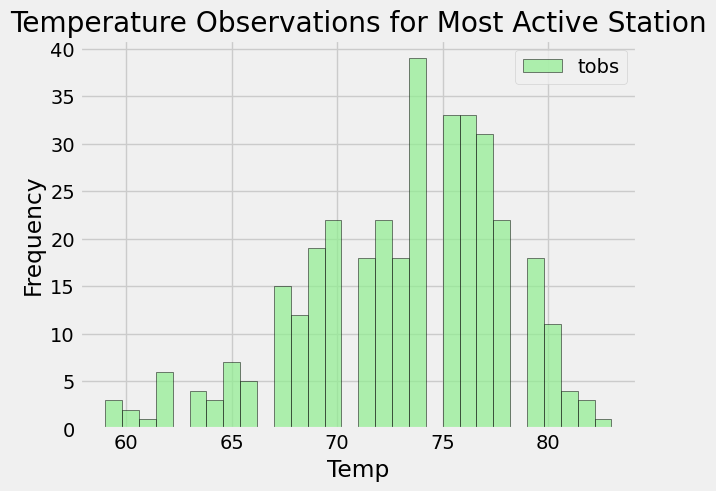

In [89]:
asi.plot.hist(y='tobs', bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title("Temperature Observations for Most Active Station")
plt.ylabel("Frequency")
plt.xlabel("Temp")
plt.show()

# Close Session

In [90]:
# Close Session
session.close()
